<a href="https://colab.research.google.com/github/adrak-sleeps/Crop-Disease-Detection-using-Drone/blob/main/Crop_disease_detection_using_VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Crop disease detection using VGG-19**

## **Download the PlantVillage Dataset**

In [ ]:
# Kaggle json file to uploaded from: https://drive.google.com/file/d/1n0C2zIUmul3OJUUjB3m4UiPiDauP5Q_l/view?usp=sharing

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ansitabehera","key":"eb8e57d47a18c3801e5d07dcb050c9c4"}\r\n\r\n'}

In [2]:
# Downloading the PlantVillage dataset from Kaggle and unzipping it
%%capture
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip /content/new-plant-diseases-dataset.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
from keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

# **Exploratory Data Analysis**

In [ ]:
#Checking the number of directories
len(os.listdir("/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"))

38

In [ ]:
#Modifying the training data for model's better learning

train_datagen = ImageDataGenerator(zoom_range= 0.5, shear_range= 0.3, horizontal_flip= True, preprocessing_function= preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [ ]:
train = train_datagen.flow_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train", target_size = (256, 256), batch_size = 32)
val = val_datagen.flow_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid", target_size = (256, 256), batch_size = 32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
t_img, label = train.next()

In [ ]:
#Checking for dimensions of any image
t_img.shape

(32, 256, 256, 3)

In [ ]:
def plotImage(img_arr, label):

  for im, l in zip(img_arr, label):
    plt.figure(figsize= (5,5))
    plt.imshow(im)
    plt.show()

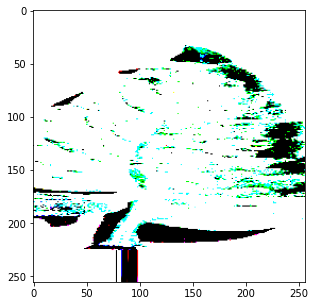

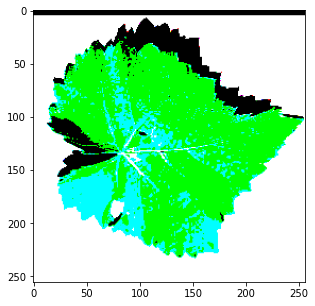

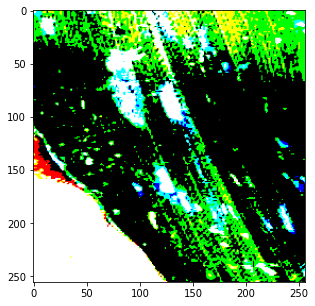

In [ ]:
#Checking some images
plotImage(t_img[:3], label[:3])

# **Building the model**

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [ ]:
#Importing the VGG-19 model
base_model = VGG19(input_shape=(256, 256, 3), include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
#Freezing the previously trained model's layers
for label in base_model.layers:
  label.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#Adding trainable layers on top of frozen layers:
#Adding a flatten layer to the base model to convert the pooled feature map into a single column
x = Flatten()(base_model.output)

#Dense adds a fully connected layer to the neural  network
x = Dense(units = 38, activation='softmax')(x)

In [ ]:
#Creating the model
model = Model(base_model.input, x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#Using adam optimizer since it gives best results 
#Categorial cross entropy coz our model outputs probabilities

model.compile(optimizer='adam', loss = keras.losses.categorical_crossentropy, metrics=['accuracy'])

# **Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience= 3, verbose= 1)

#Model check point
mc = ModelCheckpoint(filepath="best_model.h5",
                     monitor= 'val_accuracy',
                     min_delta= 0.01,
                     patience= 3,
                     verbose= 1,
                     save_best_only= True)

cb = [es, mc]

In [ ]:
#Training the model on the newly added layers
#Using fit_generator coz data augmentation has been applied

his = model.fit_generator(train,
                          epochs=10,
                          steps_per_epoch = 64,
                          verbose = 1,
                          callbacks=cb,
                          validation_data = val,
                          validation_steps= 16)

<ipython-input-25-31f0bc57ccd7>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train,


Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 15.7054 - accuracy: 0.4146
Epoch 1: val_accuracy improved from -inf to 0.67969, saving model to best_model.h5
64/64 [==============================] - 51s 612ms/step - loss: 15.7054 - accuracy: 0.4146 - val_loss: 7.0177 - val_accuracy: 0.6797
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 8.0482 - accuracy: 0.6655
Epoch 2: val_accuracy improved from 0.67969 to 0.76172, saving model to best_model.h5
64/64 [==============================] - 39s 612ms/step - loss: 8.0482 - accuracy: 0.6655 - val_loss: 6.6506 - val_accuracy: 0.7617
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 8.1655 - accuracy: 0.7119
Epoch 3: val_accuracy improved from 0.76172 to 0.79297, saving model to best_model.h5
64/64 [==============================] - 40s 622ms/step - loss: 8.1655 - accuracy: 0.7119 - val_loss: 6.3605 - val_accuracy: 0.7930
Epoch 4/10
64/64 [==============================] - ETA: 0s - los

### **The VGG-19 model achieved a validation accuracy of 85.54%.**


## **Plotting the results**

In [ ]:
#These metrics will be used to create plots
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
%matplotlib inline
plt.close('all')

## **Plotting the results**

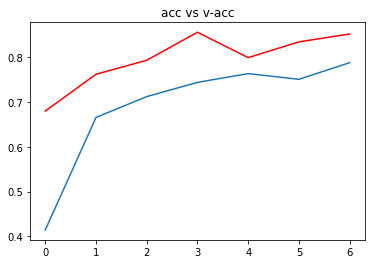

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("acc vs v-acc")
plt.show()

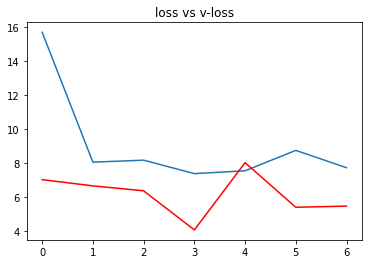

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")
plt.title("loss vs v-loss")
plt.show()

In [ ]:
#Loading the best model

from keras.models import load_model
Model = load_model("/content/best_model.h5")

In [ ]:
#Checking the accuracy
acc = Model.evaluate(val)[1]

print(f"The accuracy of your model is: {acc*100}%")

550/550 [==============================] - 105s 191ms/step - loss: 4.3223 - accuracy: 0.8509
The accuracy of your model is: 85.08991599082947%


### **This Crop Disease Detection Model using VGG-19 has an accuracy of 85.1%.**

# **Testing**

In [ ]:
#Creating a map of images and their related diseases
ref = dict( zip(list(train.class_indices.values()), list(train.class_indices.keys())))

In [ ]:
def prediction(path):
  img = load_img(path, target_size= (256, 256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im, axis = 0)

  pred = np.argmax(model.predict(img))

  print(f"The image belongs to {ref[pred]}")

In [ ]:
#Checking prediction for a leaf
path = "/content/test/test/AppleCedarRust3.JPG"
prediction(path)

1/1 [==============================] - 1s 688ms/step
The image belongs to Pepper,_bell___Bacterial_spot


In [ ]:
from torchvision.datasets import ImageFolder
test_dir = "/content/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

In [ ]:
test_images = sorted(os.listdir(test_dir + '/test')) # since images in test folder are in alphabetical order
test_images

['AppleCedarRust1.JPG',
 'AppleCedarRust2.JPG',
 'AppleCedarRust3.JPG',
 'AppleCedarRust4.JPG',
 'AppleScab1.JPG',
 'AppleScab2.JPG',
 'AppleScab3.JPG',
 'CornCommonRust1.JPG',
 'CornCommonRust2.JPG',
 'CornCommonRust3.JPG',
 'PotatoEarlyBlight1.JPG',
 'PotatoEarlyBlight2.JPG',
 'PotatoEarlyBlight3.JPG',
 'PotatoEarlyBlight4.JPG',
 'PotatoEarlyBlight5.JPG',
 'PotatoHealthy1.JPG',
 'PotatoHealthy2.JPG',
 'TomatoEarlyBlight1.JPG',
 'TomatoEarlyBlight2.JPG',
 'TomatoEarlyBlight3.JPG',
 'TomatoEarlyBlight4.JPG',
 'TomatoEarlyBlight5.JPG',
 'TomatoEarlyBlight6.JPG',
 'TomatoHealthy1.JPG',
 'TomatoHealthy2.JPG',
 'TomatoHealthy3.JPG',
 'TomatoHealthy4.JPG',
 'TomatoYellowCurlVirus1.JPG',
 'TomatoYellowCurlVirus2.JPG',
 'TomatoYellowCurlVirus3.JPG',
 'TomatoYellowCurlVirus4.JPG',
 'TomatoYellowCurlVirus5.JPG',
 'TomatoYellowCurlVirus6.JPG']

In [ ]:
dir = "/content/test/test"

#Checking predictions for the testing dataset
cnt = 0
for filename in test_images:
  cnt = cnt + 1
  print(filename)
  f = dir+'/'+filename
  prediction(f)
  print()
  print()
  
print(cnt)

AppleCedarRust1.JPG
1/1 [==============================] - 0s 36ms/step
The image belongs to Apple___Cedar_apple_rust


AppleCedarRust2.JPG
1/1 [==============================] - 0s 32ms/step
The image belongs to Apple___Cedar_apple_rust


AppleCedarRust3.JPG
1/1 [==============================] - 0s 27ms/step
The image belongs to Pepper,_bell___Bacterial_spot


AppleCedarRust4.JPG
1/1 [==============================] - 0s 20ms/step
The image belongs to Tomato___Bacterial_spot


AppleScab1.JPG
1/1 [==============================] - 0s 26ms/step
The image belongs to Apple___Apple_scab


AppleScab2.JPG
1/1 [==============================] - 0s 24ms/step
The image belongs to Apple___Apple_scab


AppleScab3.JPG
1/1 [==============================] - 0s 21ms/step
The image belongs to Apple___Apple_scab


CornCommonRust1.JPG
1/1 [==============================] - 0s 22ms/step
The image belongs to Corn_(maize)___Common_rust_


CornCommonRust2.JPG
1/1 [==============================] - 0s 23ms

The model gives correct predictions for 22 out of 33 images present in the testing dataset.

In [ ]:
#References: https://keras.io/guides/transfer_learning/